In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from imblearn.over_sampling import ADASYN
from collections import Counter
from keras.utils.data_utils import Sequence
from imblearn.keras import balanced_batch_generator

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152

from joblib import dump, load

Using TensorFlow backend.


In [44]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

In [47]:
print(x_train.shape)
print(x_train.dtype)

(6309, 180, 240, 3)
uint8


In [48]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({5: 4220, 4: 690, 2: 689, 1: 321, 0: 212, 6: 97, 3: 80})


In [49]:
######## reduction of x_train dataset

In [50]:
samples_per_class = 1750

class_members = []
list_index = np.where(y_train == 0)[0][0:samples_per_class]
for index in list_index:
    class_members.append(x_train[index])

reduct_x_train = np.array(class_members, dtype= 'float32')
reduct_y_train = np.full((list_index.shape[0],), 0, dtype='uint8')


for c in range(1,7):
    
    class_members = []
    list_index = np.where(y_train == c)[0][0:samples_per_class]
    for index in list_index:
        class_members.append(x_train[index])

    class_members = np.array(class_members, dtype= 'float32')
    print(class_members.shape)
    reduct_x_train = np.concatenate((reduct_x_train, class_members), axis=0)
    reduct_y_train = np.concatenate((reduct_y_train, 
                                     np.full((list_index.shape[0],), c, dtype='uint8')), axis=0)

(321, 180, 240, 3)
(689, 180, 240, 3)
(80, 180, 240, 3)
(690, 180, 240, 3)
(1750, 180, 240, 3)
(97, 180, 240, 3)


In [51]:
x_train = reduct_x_train
y_train = reduct_y_train

In [52]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({5: 1750, 4: 690, 2: 689, 1: 321, 0: 212, 6: 97, 3: 80})


In [ ]:
x_test = (x_test).astype('float32')/255
x_train = (x_train).astype('float32')/255
x_validation = (x_validation).astype('float32')/255

In [8]:
####### preprocessing, image flattening and reduction ######

In [54]:
original_shape = x_train.shape[1:4]
print(original_shape)

(180, 240, 3)


In [68]:
x_train = x_train.reshape(x_train.shape[0], -1)
print(x_train.shape)

(3839, 129600)


In [70]:
pca = PCA(n_components = 3000)
pca.fit(x_train)
dump(pca, 'pcaForADASYNSYS800') 

['pcaForADASYNSYS800']

In [29]:
pca = load('pcaForADASYNSYS800') 


0.781762657687068

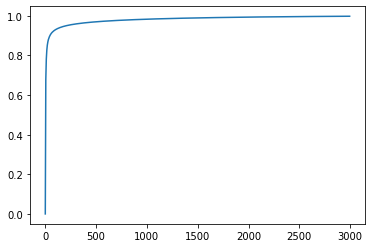

In [34]:
temp = []
for i in range(0, 3000, 5):
    temp.append(sum(pca.explained_variance_ratio_[0:i]))

plt.plot(range(0, 3000, 5), temp)
    
sum(pca.explained_variance_ratio_[0:10])

In [73]:
x_compressed = pca.transform(x_train)

In [74]:
x_compressed.shape

(3839, 3000)

In [38]:
plt.imshow(x_train[1].reshape(original_shape))

NameError: name 'x_train' is not defined

In [16]:
############  Applying SMOTE/ADASYN to augment the data ############

In [76]:

ada = ADASYN()

In [77]:
x_resampled, y_resampled = ada.fit_resample(x_compressed, y_train)

In [78]:
print(x_resampled.shape, y_resampled.shape)
print('Original dataset shape %s' % Counter(y_resampled))

(12161, 3000) (12161,)
Original dataset shape Counter({4: 1857, 3: 1766, 5: 1750, 0: 1748, 6: 1745, 1: 1721, 2: 1574})


In [82]:
x_augmented = pca.inverse_transform(x_resampled)
y_augmented = y_resampled

In [83]:
print(x_augmented.shape)
print(y_augmented.shape)

(12161, 129600)
(12161,)


In [84]:
x_augmented = x_augmented.reshape((x_augmented.shape[0],) + original_shape )

In [85]:
x_augmented.shape

(12161, 180, 240, 3)

In [86]:
np.save("D:/sys800project/x_augmentedADASYN.npy", x_augmented)
np.save("D:/sys800project/y_augmentedADASYN.npy", y_augmented)

In [ ]:
############# get saved augmented data

In [2]:
x_augmented = np.load("D:/sys800project/x_augmentedADASYN.npy")
y_augmented = np.load("D:/sys800project/y_augmentedADASYN.npy")

In [3]:
print(x_augmented.shape)
print(y_augmented.shape)
print('Augmented dataset shape %s' % Counter(y_augmented))

(12161, 180, 240, 3)
(12161,)
Augmented dataset shape Counter({4: 1857, 3: 1766, 5: 1750, 0: 1748, 6: 1745, 1: 1721, 2: 1574})


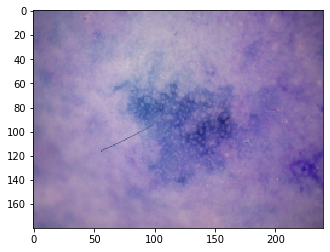

In [59]:
plt.imshow(x_augmented[0])

In [5]:
x_validation = np.load('x_validation.npy').astype('float32')/255
y_validation = np.load('y_validation.npy').astype('uint8')

x_test = np.load('x_test.npy').astype('float32')/255
y_test = np.load('y_test.npy').astype('uint8')

In [6]:
print(x_augmented.shape, y_augmented.shape, x_augmented.dtype, y_augmented.dtype)
print(x_validation.shape, y_validation.shape, x_validation.dtype, y_validation.dtype)
print(x_test.shape, y_test.shape, x_test.dtype, y_test.dtype)

(12161, 180, 240, 3) (12161,) float32 uint8
(701, 180, 240, 3) (701,) float32 int32
(3005, 180, 240, 3) (3005,) float32 int32


In [10]:
print(x_augmented[0,0,0,0], x_validation[0,0,0,0], x_test[0,0,0,0])

0.40111947 0.74509805 0.65882355


In [ ]:
###### differentiate synthetic from not synthetic data

In [65]:
print(x_train.shape)

(3839, 180, 240, 3)


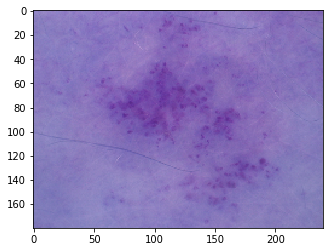

IndexError: index 12000 is out of bounds for axis 0 with size 3839

In [91]:
i = 12000
plt.imshow(x_augmented[i])
plt.show()
plt.imshow(x_train[i])
plt.show()

In [3]:
##### CNN model creation

In [11]:
resnet152 = ResNet152(include_top=False, weights='imagenet', input_shape=x_augmented.shape[1:])

In [12]:
model = Sequential([
  resnet152
])


In [13]:
model.add(GlobalAveragePooling2D()) 
model.add(Dropout(0.2))

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))

#model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(7, activation = 'softmax'))
#model.add(Activation('softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 6, 8, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 3591      
Total params: 59,423,623
Trainable params: 59,272,199
Non-trainable params: 151,424
______________________________________

In [15]:
model.load_weights('resnet152_augmentedADASYN')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for resnet152_augmentedADASYN

In [8]:
########################## Common part: optimization and training#############################################

In [16]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [17]:
model.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
#datagen.fit(x_augmented)

In [21]:
epochs = 40
batch_size = 10
history = model.fit_generator(
    datagen.flow(x_augmented,y_augmented, batch_size=batch_size),
    steps_per_epoch=x_augmented.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validation,y_validation),
    validation_steps=x_validation.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

Epoch 1/40
1216/1216 [==============================] - 1601s 1s/step - loss: 1.6065 - accuracy: 0.3692 - val_loss: 1.1406 - val_accuracy: 0.5050
Epoch 2/40
1216/1216 [==============================] - 1558s 1s/step - loss: 1.2440 - accuracy: 0.5169 - val_loss: 4.8340 - val_accuracy: 0.2254
Epoch 3/40
1216/1216 [==============================] - 1525s 1s/step - loss: 1.1180 - accuracy: 0.5816 - val_loss: 3.3449 - val_accuracy: 0.3581
Epoch 4/40
1215/1216 [============================>.] - ETA: 1s - loss: 0.9711 - accuracy: 0.6329
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1216/1216 [==============================] - 1542s 1s/step - loss: 0.9712 - accuracy: 0.6328 - val_loss: 1.5139 - val_accuracy: 0.4223
Epoch 5/40
1216/1216 [==============================] - 1534s 1s/step - loss: 0.7582 - accuracy: 0.7125 - val_loss: 0.7779 - val_accuracy: 0.6605
Epoch 6/40
1216/1216 [==============================] - 1540s 1s/step - loss: 0.7019 - accuracy: 0.7329

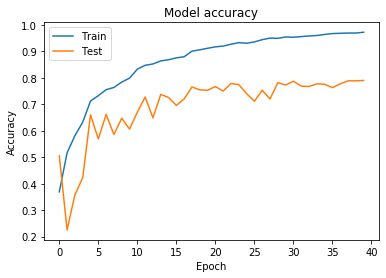

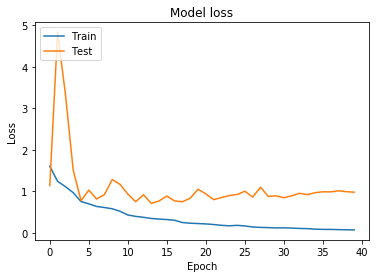

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [23]:
#### Saving the weights of the model for a later use.


model.save_weights('resnet152_augmentedADASYN')

In [24]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)

3005/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [25]:
##### confusion matrix

pred = model.predict(x_test)
pred_label = np.zeros(len(y_test), dtype='uint8')

for i in range(len(pred)):
    pred_label[i] = int(np.argmax(pred[i]))
    

In [26]:
confusion = confusion_matrix(y_test, pred_label)

In [27]:
print(confusion)
print('predicted is horizontal, true label is vertical')

[[  44    7   19    1   15    6    0]
 [  11   94   22    4    6   22    0]
 [   5    8  215    3   41   68    0]
 [   1    0    4   17    1    4    0]
 [   2    4   34    0  180  115    1]
 [   3   19   87    8  163 1737    1]
 [   0    3    0    1    1    2   26]]
predicted is horizontal, true label is vertical
